In [76]:
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import svm
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'Raw_debates')
RESULT_DIR = os.path.join(ROOT_DIR, 'candidate_lines')

candidates = {'CLINTON', 'SANDERS', 'TRUMP', 'RUBIO', 'CRUZ'}
cand_list = sorted(candidates)

stops = set(stopwords.words("english"))

%matplotlib inline

In [77]:
word_dic = {'action': 'act',
               'agreement': 'agree',
               'americans': 'american',
               'asked': 'ask',
               'asking': 'ask',
               'going': 'go',
               'states': 'state',
               'working': 'work',
               'millions': 'million',
               'bringing': 'bring',
               'businesses': 'business',
               'candidates': 'candidate',
               'children': 'child',
               'comes': 'come',
               'coming': 'come',
               'companies': 'company',
               'countries': 'country',
               'deals': 'deal',
               'economic': 'economy',
               'families': 'family',
               'fighting': 'fight',
               'gets': 'get',
               'getting': 'get',
               'goes': 'go',
               'got': 'get',
               'groups': 'group',
               'guns': 'gun',
               'happened': 'happen',
               'happening': 'happen',
               'helped': 'help',
               'issues': 'issue',
               'knows': 'know',
               'laws': 'law',
               'lives': 'live',
               'living': 'live',
               'making': 'make',
               'needs': 'need',
               'passed': 'pass',
               'problems': 'problem',
               'putting': 'put',
               'really': 'real',
               'republicans': 'republican',
               'running': 'run',
               'saying': 'say',
               'said': 'say',
               'seeing': 'see',
               'seen': 'see',
               'started': 'start',
               'supported': 'support',
               'taking': 'take',
               'talked': 'talk',
               'talking': 'talk',
               'terrorists': 'terrorist',
               'terrorism': 'terrorist',
               'things': 'thing',
               'trying': 'try',
               'used': 'use',
               'using': 'use',
               'voted': 'vote',
               'wages': 'wage',
               'wanted': 'want',
               'wants': 'want',
               'building': 'build',
               'called': 'call',
               'came': 'come',
               'communities': 'community',
               'costs': 'cost',
               'deffence': 'deffend',
               'difference': 'different',
               'drugs': 'drug',
               'gave': 'give',
               'given': 'give',
               'gone': 'go',
               'higher': 'high',
               'highest': 'high',
               'interests': 'interest',
               'jobs': 'job',
               'longer': 'long',
               'looked': 'look',
               'looking': 'look',
               'lost': 'lose',
               'made': 'make',
               'means': 'mean',
               'paying': 'pay',
               'planned': 'plan',
               'programs': 'program',
               'raising': 'raise',
               'reasons': 'reason',
               'ringing': 'ring',
               'says': 'say',
               'saw': 'see',
               'wealthy': 'wealth',
               'worked': 'work',
               'allowed': 'allow',
               'built': 'build',
               'years': 'year'}

In [78]:
block_dic = {}

def get_raw_text(cand_name):
    file_name = '{0}.txt'.format(cand_name)
    file_path = os.path.join(RESULT_DIR, file_name)
    with open(file_path, 'rb') as f:
        return f.read()

def raw_to_blocks(cand_name, raw_text, delimiter='\r\n\r\n', min_len=200):
    # Delete candidate's name
    names_removed = raw_text.replace(cand_name + ':', '')
    
    # Split the text into paragraphs
    splitted = names_removed.split(delimiter)

    # Gather only long enough paragraphs
    rets = [paragraph for paragraph in splitted if len(paragraph) > min_len]
    return rets

# Replace words that are virtually same into one word. 
def hard_code_process(text):
    separate_word = ' {0} '
    text = separate_word.format(text)
    
    for key, value in word_dic.iteritems():
        key = separate_word.format(key)
        value = separate_word.format(value)
        text = text.replace(key, value)
    return text

def process_paragraph(paragraph):
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", paragraph) 
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    rets = ' '.join(meaningful_words)
    return hard_code_process(rets)

def get_processed_lines(cand_name, delimiter='\r\n\r\n', min_len=200):
    raw_text = get_raw_text(cand_name)
    blocks = raw_to_blocks(cand_name, raw_text, 
                           delimiter=delimiter, min_len=min_len)
    ret = map(process_paragraph, blocks)
    for k, v in zip(ret, blocks):
        block_dic[k] = v
    return ret

def get_vectorizer(cand_lines, max_features=1000):
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = max_features)
    
    concatenated = []
    for cand_name, lines in cand_lines.iteritems():
        concatenated += lines
    
    vectorizer.fit(concatenated)
    return vectorizer

In [79]:
# Split training data and test data
def test_train_split(cand_lines, test_ratio=0.25):
    cands = cand_lines.keys()
    test_data = dict.fromkeys(cands)
    train_data = dict.fromkeys(cands)
    for c in cands:
        lines = cand_lines[c]
        l = len(lines)
        test_len = int(l * test_ratio)
        test_indices = set(np.random.choice(l, test_len, replace=False))
        train_indices = set(range(l)) - test_indices
        test_data[c] = list(np.take(lines, list(test_indices)))
        train_data[c] = list(np.take(lines, list(train_indices)))
    return test_data, train_data

def normalize(data):
    rets = dict()
    for c in data:
        d = data[c].astype(float)
        _sum = d.sum(axis=1)
        _sum[_sum==0] = 1
        rets[c] = (d.T / _sum).T
    return rets

def pie_chart(vector, vocab):
    vocab = np.array(vocab)
    cond = vector > 0
    words = vocab[cond]
    sizes = vector[cond]
    plt.pie(sizes, labels=words)

In [80]:
# Process the data

cand_lines = {c: get_processed_lines(c, min_len=200) for c in candidates}
raw_test_data, raw_train_data = test_train_split(cand_lines, 0.25)
train_data = dict.fromkeys(cand_list)
test_data = dict.fromkeys(cand_list)

vectorizer = get_vectorizer(raw_train_data, 500)
vocab = vectorizer.get_feature_names()

for c in train_data:
    train_data[c] = vectorizer.transform(raw_train_data[c]).toarray()
    test_data[c] = vectorizer.transform(raw_test_data[c]).toarray()

train_data = normalize(train_data)
test_data = normalize(test_data)

train_x, test_x = None, None
train_y, test_y = [], []

raw_train_x, raw_test_x = [], []

for c in train_data:
    i  = cand_list.index(c)
    if train_x is None:
        train_x = train_data[c]
    else:
        train_x = np.concatenate((train_x, train_data[c]))
    raw_train_x += raw_train_data[c]
    train_y += [i] * len(train_data[c])
    
for c in test_data:
    i  = cand_list.index(c)
    if test_x is None:
        test_x = test_data[c]
    else:
        test_x = np.concatenate((test_x, test_data[c]))
    raw_test_x += raw_test_data[c]
    test_y += [i] * len(test_data[c])
    
train_y = np.array(train_y)
test_y = np.array(test_y)

def to_actual_line(i):
    key = raw_test_x[i]
    return block_dic[key]

In [81]:
# Unigram model

p_mle = DataFrame(columns=cand_list)

for i, c in enumerate(cand_list):
    p_mle[c] = train_x[train_y == i].mean(0)
    
def predict_proba(x):
    scores = []
    for c in cand_list:
        scores.append(np.dot(x, p_mle[c]))
    scores = np.array(scores)
    return scores / sum(scores)

def predict(x):
    prob = predict_proba(x)
    return np.argmax(prob)

def evaluate(x, y):
    l = len(x)
    num_correct = 0
    for sample, answer in zip(x, y):
        if predict(sample) == answer:
            num_correct += 1
    return float(num_correct) / l

evaluate(test_x, test_y)

0.537864077669903

In [82]:
# Top words for each candidate

normalized_p_mle = DataFrame(columns=cand_list)
for c in cand_list:
    normalized_p_mle[c] = p_mle[c] / p_mle.sum(1)

def top_words(c, num_words=10):
    indices = normalized_p_mle[c].sort_values().index[-num_words:]
    return np.array(vocab)[indices]

def word_pie_chart(word):
    i = vocab.index(word)
    sizes = normalized_p_mle.iloc[i]
    plt.title('Word: ' + word)
    plt.pie(sizes, labels=cand_list)

num_words = 30
df = DataFrame(columns=cand_lines)
for c in cand_lines:
    df[c] = top_words(c, num_words)[::-1]
df

,SANDERS,CRUZ,CLINTON,RUBIO,TRUMP
0,large,growth,sanders,century,tremendous
1,billionaires,simple,affordable,especially,frankly
2,secretary,flat,possible,st,mexico
3,contributions,note,agenda,someone,nobody
4,super,islamic,questions,already,oil
5,class,focus,senator,less,along
6,earth,dad,particularly,gonna,read
7,establishment,amnesty,move,threat,probably
8,view,court,prevent,illegally,love
9,major,donald,comprehensive,trust,thousands


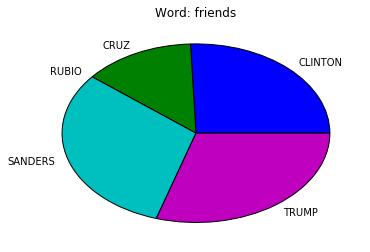

In [89]:
word_pie_chart('friends')

In [27]:
# Predicted probability dataframe

proba = []

for x in test_x:
    proba.append(predict_proba(x))
    
proba_df = DataFrame(proba, columns=cand_list)
proba_df.describe()

,CLINTON,CRUZ,RUBIO,SANDERS,TRUMP
count,515.000000,515.000000,515.000000,515.000000,515.000000
mean,0.204886,0.175037,0.198454,0.201836,0.219787
std,0.034766,0.043488,0.035976,0.032095,0.045331
min,0.102763,0.097483,0.103850,0.109458,0.082110
25%,0.182124,0.144570,0.173380,0.182581,0.187571
50%,0.202600,0.164788,0.196018,0.201283,0.221330
75%,0.226236,0.192914,0.219988,0.220837,0.250303
max,0.359953,0.345572,0.331958,0.319807,0.367715


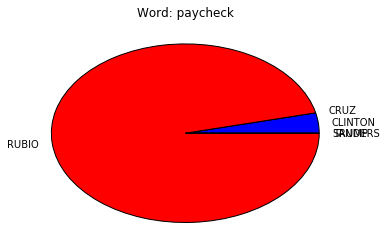

In [139]:
# High classifying power words    
indices = normalized_p_mle.std(1).sort_values().index[::-1]

j += 1
i = indices[j]

sizes = p_mle.iloc[i]
sizes /= sum(sizes)
plt.title('Word: {0}'.format(vocab[i]))
plt.pie(sizes, labels=p_mle.columns)
print 